In [2]:
import sys

import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import platform
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available


In [29]:
#Load data
df = pd.read_csv('data_cleaned.csv')
df = df.iloc[:, :16]
print(len(df.index))

#Instead of dropping rows where plant is off, convert the row to zero
df.loc[df['Coal Input'] < 0] = 0

# Prints a specified row of the df
#print(df.iloc[[10000,20000]])

32768


In [30]:
# apply MinMaxScaler to the dataframe
# scaler = MinMaxScaler()
# scaled_df = scaler.fit_transform(df)

# #convert the numpy scaled array back to a dataframe
# df_scaled = pd.DataFrame(scaled_df, columns=df.columns)
df_scaled = df

In [31]:
df_scaled['Power Plant On'] = (df_scaled['Coal Input'] > 0).astype(int)

dataframes = []
indices = []
for index, row in df_scaled.iterrows():
    if row['Power Plant On'] == 0:
        if indices:
            dataframes.append(df_scaled.loc[indices].copy())
            indices = []
    else:
        indices.append(index)

# Check if there are any remaining indices after the loop ends
if indices:
    dataframes.append(df_scaled.loc[indices].copy())

# Print the number of different datasets and their lengths
print(f"Number of datasets: {len(dataframes)}")
#for i, dataset in enumerate(dataframes):
    #print(f"Dataset {i+1} length: {len(dataset)}")

# Calculate the total number of rows
total_rows = sum(len(dataset) for dataset in dataframes)
print(f"Total number of rows: {total_rows}")


Number of datasets: 3
Total number of rows: 31774


In [36]:
# Iterate over each column in the DataFrame
for column_name in df_scaled.columns:

    # Calculate z-scores to identify outliers
    z_scores = (df_scaled[column_name] - df_scaled[column_name].mean()) / df_scaled[column_name].std()
    outliers_count = sum(abs(z_scores) > 3)  # Adjust the threshold as needed

    # Print the count of outliers for the column
    print("Outliers count in", column_name, ":", outliers_count)


Outliers count in ECO SYS FW Supply SATN T : 0
Outliers count in Economizer SYS FW Supply P : 0
Outliers count in HP Steam Average Temp : 0
Outliers count in Hot R/H Average Temp : 0
Outliers count in Live Steam TOT F : 0
Outliers count in ATT 1 m_dot : 0
Outliers count in ATT 2 m_dot : 118
Outliers count in R/H ATT m_dot : 0
Outliers count in AMB Air T : 77
Outliers count in Coal Input : 0
Outliers count in BLR Primary Air F : 0
Outliers count in BLR Secondary Air Total F : 0
Outliers count in OVR FIR CORR Air NOZ 71-73 F : 0
Outliers count in OVR FIR CORR Air NOZ 74-76 F : 0
Outliers count in OVR FIR CORR Air NOZ 81-83 F : 0
Outliers count in OVR FIR CORR Air NOZ 84-86 F : 0
Outliers count in Power Plant On : 994


In [6]:
def timewindow_df(df, timeBackWindow, timeForwardWindow):
    # timeBackWindow = 5
    # timeForwardWindow = 2

    # Define column names for the first part
    cols_part1 = ['ECO SYS FW Supply SATN T', 'Economizer SYS FW Supply P', 'Live Steam TOT F',
                  'AMB Air T', 'Coal Input', 'BLR Primary Air F', 'BLR Secondary Air Total F',
                  'OVR FIR CORR Air NOZ 71-73 F', 'OVR FIR CORR Air NOZ 74-76 F',
                  'OVR FIR CORR Air NOZ 81-83 F', 'OVR FIR CORR Air NOZ 84-86 F']
    # Define column names for the second part
    cols_part2 = ['HP Steam Average Temp', 'Hot R/H Average Temp', 'ATT 1 m_dot', 'ATT 2 m_dot', 'R/H ATT m_dot']
    # Shift rows and concatenate for both parts
    df_temp = pd.DataFrame()

    for col in cols_part1 + cols_part2:
        # Shift columns forward for the first part
        if col in cols_part1:
            df_new = pd.concat([df[col].shift(-i) for i in range(timeBackWindow-1, -1, -1)], axis=1, 
                               keys=[f'{col}-{i}' for i in range(timeBackWindow)])
        # Shift columns backward for the second part
        else:
            shifted_cols = [df[col].shift(i) for i in range(timeForwardWindow)]
            df_new = pd.concat(shifted_cols, axis=1, 
                               keys=[f'{col}+{i}' for i in range(timeForwardWindow)])
        # Concatenate the resulting dataframe with df_temp, along the columns axis (axis=1)
        df_temp = pd.concat([df_temp, df_new], axis=1)

    return df_temp


In [7]:
#Time window the datasets
manipulated_dataframes = []

for df in dataframes:
    manipulated_df = timewindow_df(df,5,2)
    manipulated_dataframes.append(manipulated_df)


# Print the number of rows for each dataset in the manipulated dataframes
print(f"Number of manipulated datasets: {len(manipulated_dataframes)}")
#for i, dataset in enumerate(manipulated_dataframes):
    #print(f"Manipulated Dataset {i+1} length: {len(dataset)}")

# Calculate the total number of rows across all the manipulated datasets
total_rows = sum(len(dataset) for dataset in manipulated_dataframes)

# Print the total number of rows
print(f"Total number of rows: {total_rows}")

Number of manipulated datasets: 32
Total number of rows: 22565


In [8]:
# Remove rows with NaN values from each dataframe
manipulated_dataframes_cleaned = []
for dataset in manipulated_dataframes:
    cleaned_dataset = dataset.dropna()
    manipulated_dataframes_cleaned.append(cleaned_dataset)

# Print the number of rows for each dataset in the cleaned manipulated dataframes
print(f"Number of manipulated datasets: {len(manipulated_dataframes_cleaned)}")
#for i, dataset in enumerate(manipulated_dataframes_cleaned):
    #print(f"Manipulated Dataset {i+1} length: {len(dataset)}")

# Calculate the total number of rows across all the cleaned manipulated datasets
total_rows = sum(len(dataset) for dataset in manipulated_dataframes_cleaned)

# Print the total number of rows
print(f"Total number of rows: {total_rows}")

Number of manipulated datasets: 32
Total number of rows: 22412


In [9]:
# Concat datasets
processed_df = pd.concat(manipulated_dataframes_cleaned, ignore_index=True)

In [10]:
processed_df.head()

,ECO SYS FW Supply SATN T-0,ECO SYS FW Supply SATN T-1,ECO SYS FW Supply SATN T-2,ECO SYS FW Supply SATN T-3,ECO SYS FW Supply SATN T-4,Economizer SYS FW Supply P-0,Economizer SYS FW Supply P-1,Economizer SYS FW Supply P-2,Economizer SYS FW Supply P-3,Economizer SYS FW Supply P-4,...,HP Steam Average Temp+0,HP Steam Average Temp+1,Hot R/H Average Temp+0,Hot R/H Average Temp+1,ATT 1 m_dot+0,ATT 1 m_dot+1,ATT 2 m_dot+0,ATT 2 m_dot+1,R/H ATT m_dot+0,R/H ATT m_dot+1
0,328.273865,327.268189,326.876099,325.125336,325.590851,12.379500,12.211500,12.148501,11.865001,11.959500,...,462.827087,448.472938,440.429176,433.766678,1.021098,8.820438,4.816306,7.129189,15.502309,11.206032
1,327.885803,328.273865,327.268189,326.876099,325.125336,12.274500,12.379500,12.211500,12.148501,11.865001,...,481.406250,462.827087,456.327087,440.429176,5.002522,1.021098,7.593607,4.816306,15.191876,15.502309
2,327.885803,327.885803,328.273865,327.268189,326.876099,12.348000,12.274500,12.379500,12.211500,12.148501,...,495.272934,481.406250,471.439591,456.327087,7.204206,5.002522,7.306595,7.593607,17.742356,15.191876
3,328.756805,327.885803,327.885803,328.273865,327.268189,12.458251,12.348000,12.274500,12.379500,12.211500,...,511.604164,495.272934,487.472931,471.439591,17.061391,7.204206,6.484607,7.306595,16.392641,17.742356
4,328.273865,328.756805,327.885803,327.885803,328.273865,12.416250,12.458251,12.348000,12.274500,12.379500,...,523.385437,511.604164,502.829185,487.472931,4.024954,17.061391,1.636576,6.484607,11.975489,16.392641


In [11]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(processed_df)
# #convert the numpy scaled array back to a dataframe
processed_df = pd.DataFrame(scaled_df, columns=processed_df.columns)

In [12]:
# Iterate over each column

for column in processed_df.columns:
    # Count the occurrence of each unique value
    value_counts = processed_df[column].value_counts()
    # Check if zero is present and get its count
    zero_count = value_counts[0] if 0 in value_counts.index else 0
    
    # Print the count of zeros for the column
    print(f"Column '{column}' has {zero_count} zeros.")


Column 'ECO SYS FW Supply SATN T-0' has 1 zeros.
Column 'ECO SYS FW Supply SATN T-1' has 1 zeros.
Column 'ECO SYS FW Supply SATN T-2' has 1 zeros.
Column 'ECO SYS FW Supply SATN T-3' has 1 zeros.
Column 'ECO SYS FW Supply SATN T-4' has 1 zeros.
Column 'Economizer SYS FW Supply P-0' has 2 zeros.
Column 'Economizer SYS FW Supply P-1' has 2 zeros.
Column 'Economizer SYS FW Supply P-2' has 2 zeros.
Column 'Economizer SYS FW Supply P-3' has 2 zeros.
Column 'Economizer SYS FW Supply P-4' has 2 zeros.
Column 'Live Steam TOT F-0' has 1 zeros.
Column 'Live Steam TOT F-1' has 1 zeros.
Column 'Live Steam TOT F-2' has 1 zeros.
Column 'Live Steam TOT F-3' has 1 zeros.
Column 'Live Steam TOT F-4' has 1 zeros.
Column 'AMB Air T-0' has 1 zeros.
Column 'AMB Air T-1' has 1 zeros.
Column 'AMB Air T-2' has 1 zeros.
Column 'AMB Air T-3' has 1 zeros.
Column 'AMB Air T-4' has 1 zeros.
Column 'Coal Input-0' has 1 zeros.
Column 'Coal Input-1' has 1 zeros.
Column 'Coal Input-2' has 1 zeros.
Column 'Coal Input-3

In [13]:
#Split data into the test
# x_data = df[['ECO SYS FW Supply SATN T', 'Economizer SYS FW Supply P', 'Live Steam TOT F','AMB Air T','Coal Input',
#              'BLR Primary Air F','BLR Secondary Air Total F','OVR FIR CORR Air NOZ 71-73 F','OVR FIR CORR Air NOZ 74-76 F',
#              'OVR FIR CORR Air NOZ 81-83 F','OVR FIR CORR Air NOZ 84-86 F',]].values
# y_data = df[['HP Steam Average Temp', 'Hot R/H Average Temp', 'ATT 1 m_dot', 'ATT 2 m_dot', 'R/H ATT m_dot']].values

# Train the model on each dataset separately

# num_datasets = len(manipulated_dataframes_cleaned)
# num_train_datasets = round(num_datasets * 0.9)

x_cols = 5 * 11  # Adjust this based on the time windowing performed
x_data = processed_df.iloc[:, :x_cols].values
y_data = processed_df.iloc[:, x_cols:].values

print("True")
print(x_data.shape)
print(y_data.shape)

print("Adapated")
x_train = x_data[:int(0.9*x_data.shape[0]),:]
print(x_train.shape)
x_test = x_data[int(0.9*x_data.shape[0]):,:]
print(x_test.shape)
y_train = y_data[:int(0.9*y_data.shape[0]),:]
print(y_train.shape)
y_test = y_data[int(0.9*y_data.shape[0]):,:]
print(y_test.shape)


True
(22412, 55)
(22412, 10)
Adapated
(20170, 55)
(2242, 55)
(20170, 10)
(2242, 10)


In [14]:
# model = keras.models.Sequential()
# # Add the input layer
# model.add(keras.layers.Dense(units=64, input_shape=(55,), activation='relu'))

# # Add the hidden layers
# for units in [32,16]:
#     model.add(keras.layers.Dense(units, activation='relu'))

# # Add the output layer
# model.add(keras.layers.Dense(10, activation='linear'))


# loss_fn = tf.keras.losses.MeanSquaredError()
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

# model.summary()

# hist = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

In [16]:
class MyNeuralNetwork(keras.Model):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.input_layer = keras.layers.Dense(units=64, input_shape=(55,), activation='relu')
        self.hidden_layers = [keras.layers.Dense(units=32, activation='relu'),
                              keras.layers.Dense(units=16, activation='relu')]
        self.output_layer = keras.layers.Dense(units=10, activation='linear')

    def call(self, inputs):
        x = self.input_layer(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

model = MyNeuralNetwork()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

# Build the model before training
model.build((None, 55))

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Model: "my_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  3584      
                                                                 
 dense_5 (Dense)             multiple                  2080      
                                                                 
 dense_6 (Dense)             multiple                  528       
                                                                 
 dense_7 (Dense)             multiple                  170       
                                                                 
Total params: 6,362
Trainable params: 6,362
Non-trainable params: 0
_________________________________________________________________


In [17]:

hist = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


2023-05-23 20:32:50.502567: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/505 [..............................] - ETA: 3:56 - loss: 0.6859 - mean_absolute_percentage_error: 107.4724 - root_mean_squared_error: 0.8282

2023-05-23 20:32:50.784589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


505/505 [==============================] - ETA: 0s - loss: 0.3019 - mean_absolute_percentage_error: 30579.8535 - root_mean_squared_error: 0.5495

2023-05-23 20:32:53.710150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


505/505 [==============================] - 4s 6ms/step - loss: 0.3019 - mean_absolute_percentage_error: 30579.8535 - root_mean_squared_error: 0.5495 - val_loss: 0.1067 - val_mean_absolute_percentage_error: 23652.6992 - val_root_mean_squared_error: 0.3266
Epoch 2/50
505/505 [==============================] - 3s 6ms/step - loss: 0.0536 - mean_absolute_percentage_error: 59590.0625 - root_mean_squared_error: 0.2315 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 30189.2168 - val_root_mean_squared_error: 0.1604
Epoch 3/50
505/505 [==============================] - 3s 6ms/step - loss: 0.0211 - mean_absolute_percentage_error: 62179.5273 - root_mean_squared_error: 0.1452 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 32316.5293 - val_root_mean_squared_error: 0.1526
Epoch 4/50
505/505 [==============================] - 3s 6ms/step - loss: 0.0191 - mean_absolute_percentage_error: 63772.6016 - root_mean_squared_error: 0.1383 - val_loss: 0.0222 - val_mean_absolute_percentage_err

In [19]:
loss, MAPE, RMSE = model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 4ms/step - loss: 0.0125 - mean_absolute_percentage_error: 16.7030 - root_mean_squared_error: 0.1119


In [20]:
forecast = model.predict(x_test)


71/71 [==============================] - 0s 2ms/step


2023-05-23 20:38:43.950152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


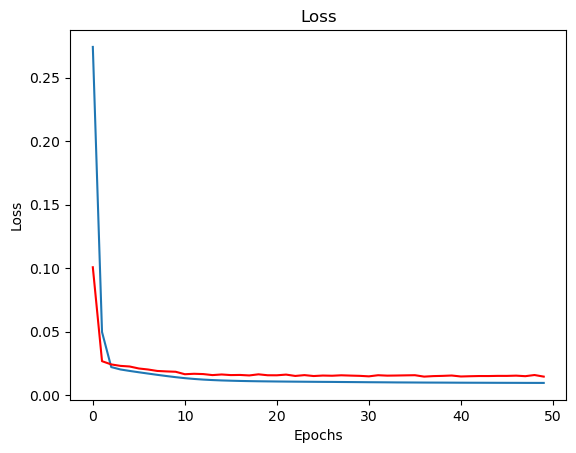

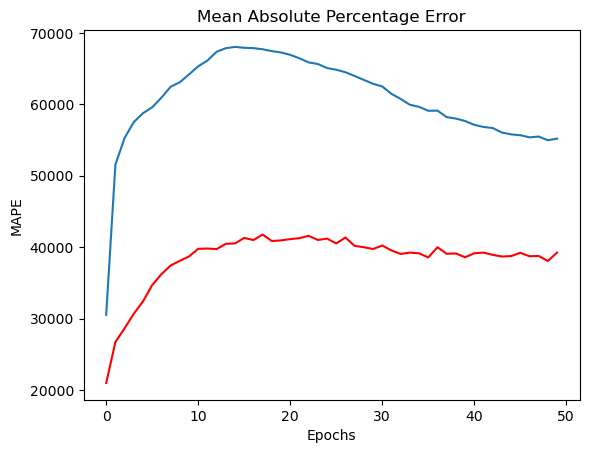

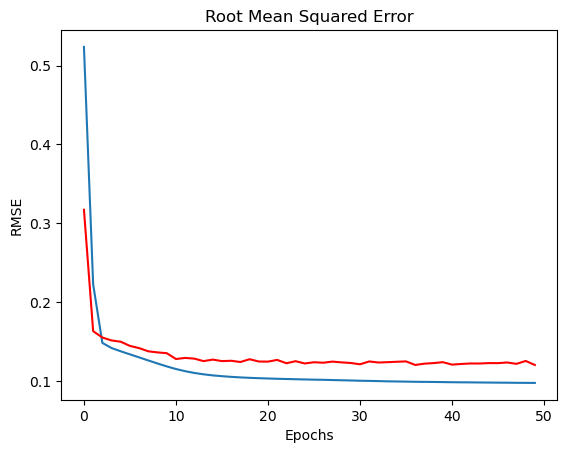

In [29]:
# Plot the training loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'], color="red")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the training metrics
plt.plot(hist.history['mean_absolute_percentage_error'])
plt.plot(hist.history['val_mean_absolute_percentage_error'], color="red")
plt.title('Mean Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.show()

# Plot the training metrics
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'], color="red")
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()
